# Signal trading

1. Illustrative example of signal trading through turtle trading signal and moving average signal

2. Buy-and-hold strategy

NEED TO DO: CORRECT SELL ORDER IN MOVING AVERAGE - AFFECT TRANSACTION COSTS - METRIQUES DRAWDOWN ON BUYnHOLD

## 1. load the libraries and constants

In [27]:
# To support both python 2 and python 3
from __future__ import division, print_function, unicode_literals

import numpy as np
import pandas as pd
import os

SOURCE_FOLDER = 'Data-processed'
TARGET_FOLDER = 'Data-factor'

DESCRIPTION_FILE = "data_list.csv"
DATA_FILE = "data_content.csv"

INVESTMENT = 10000

## 2. load the data

In [28]:
# Use only the time-series and the static dataset. 
df_desc = pd.read_csv(os.path.join(os.getcwd(),SOURCE_FOLDER, DESCRIPTION_FILE),encoding='utf-8',index_col=0)
df_data = pd.read_csv(os.path.join(os.getcwd(),SOURCE_FOLDER, DATA_FILE),encoding='utf-8', index_col=0)

# trading signal
df_signal_ma = pd.read_csv(os.path.join(os.getcwd(),TARGET_FOLDER, 'moving_average_signal.csv'), encoding='utf-8',index_col=0)
df_turtle = pd.read_csv(os.path.join(os.getcwd(),TARGET_FOLDER, 'turtle_signal.csv'), encoding='utf-8',index_col=0)

## 3. Signal trading

In [103]:
# Presentation to buy the stock and illustrate
def buy_stock(real_movement, signal, initial_money = INVESTMENT, max_buy = 1, max_sell = 1):
    """
    real_movement = Stock price time-series - pandas dataframe
    signal = Buy/Sell signals - pandas dataframe
    initial_money: Value of funds to invest (unitary monetary value, i.e. USD)
    max_buy : Quantity to buy at each positive signal
    max_sell : Quantity to sell at each negative signal
    """
    starting_money = initial_money
    states_sell = []
    states_buy = []
    current_inventory = 0  # inventory of the stocks (Check that we don't invest all)
    return_array =[]
    def buy(i, initial_money, current_inventory):
        """
        Implement the buy signal
        i: position index - get the date of the index
        initial_money: Cash amount available at t
        current_inventory: inventory of stock - positive integer
        """
        shares = initial_money // real_movement[i]  # Get the number available (floor int)
#         print("Value money", initial_money)
#         print( "Stock", np.isnan(real_movement[i]))
#         print( "Stock", real_movement.index[i])
#         print( "Nb shares", shares)
        if shares < 1:
            print('day nb %d -date %s: total balances %f, not enough money to buy a unit price %f'
                % (i, real_movement.index[i],  initial_money, real_movement[i]))
        else:
            if shares > max_buy:  # Buy the nb max of shares per new signal
                buy_units = max_buy
            else:
                buy_units = shares  # Buy the remaining shares
            initial_money -= buy_units * real_movement[i]  # Decrease the amount of money
            current_inventory += buy_units  # Increase the inventory
            print('day nb %d -date %s: buy %d units at price %f, total balance %f'
                % (i, real_movement.index[i], buy_units, buy_units * real_movement[i], initial_money))
            #states_buy.append(0)  # Flag buy stock states_buy.append(i) but elsewhere
        return initial_money, current_inventory
    
    # Loop over the time index
    for i in range(real_movement.shape[0] - int(0.025 * real_movement.shape[0])):
        state = signal[i]  # Collec
        if state == 1: # signal to increase position - buy 
            # Check if value is NaN to avoid crash
            if not np.isnan(real_movement[i]): 
                initial_money, current_inventory = buy(i, initial_money, current_inventory)
                states_buy.append(i)
        elif state == -1: # signal to decrease position - sell 
            if not np.isnan(real_movement[i]): 
                if current_inventory == 0:
                        print('day nb %d -date %s: cannot sell anything, inventory 0' % (i, real_movement.index[i]))
#                         print(i)
#                         print(real_movement.index[i])
#                         print("Value money", initial_money)
#                         print( "Stock", np.isnan(real_movement[i]))
#                         print( "Stock", real_movement.index[i])
                else:
                    if current_inventory > max_sell:
                        sell_units = max_sell  # Adjust from maximum selling
                    else:
                        sell_units = current_inventory  # Reduce to zero
                    current_inventory -= sell_units
                    total_sell = sell_units * real_movement[i]
                    initial_money += total_sell  # add back to the pot
                    try:
                        invest = (  # rate of return from the last buy position: states_buy[-1]
                            (real_movement[i] - real_movement[states_buy[-1]])
                            / real_movement[states_buy[-1]]
                        ) * 100
                    except:
                        invest = 0
                    # Compute the return of investment so far - Stack invest.
                    if invest > 1:
                        print("invest",invest)
                        print("position",i)
                        print("Date",real_movement.index[i])
                        print("Value money end", real_movement[i])
                        print("Value money start", real_movement[states_buy[-1]])
                        print( "Position start", states_buy[-1])
                        
                    return_array.append(invest)
                    print('day nb %d -date %s, sell %d units at price %f, investment %f %%, total balance %f,'
                        % (i, real_movement.index[i], sell_units, total_sell, invest, initial_money))
                    states_sell.append(i)
#                     print("end",i)
#                     print("end",real_movement.index[i])
#                     print("Value money", initial_money)
#                     print( "Stock", np.isnan(real_movement[i]))
#                     print( "Stock", real_movement.index[i])
    # After trading we need to close the position
    if current_inventory>0:
        total_sell = current_inventory * real_movement[
            max(range(real_movement.shape[0] - int(0.025 * real_movement.shape[0])))]
        initial_money += total_sell  # add back to the pot
        current_inventory = 0
#     print(real_movement[max(range(real_movement.shape[0] - int(0.025 * real_movement.shape[0])))])
#     print(current_inventory)
#     print(initial_money)
    invest = ((initial_money - starting_money) / starting_money) * 100
    total_gains = initial_money - starting_money
    return states_buy, states_sell, total_gains, invest, return_array

In [125]:
# Execution with turtle for one stock
states_buy, states_sell, total_gains, invest, return_array = buy_stock(df_data['PA1436583006-P'], df_turtle['PA1436583006-FTURTLE'])

day nb 10 -date 2004-01-16: cannot sell anything, inventory 0
day nb 12 -date 2004-01-20: cannot sell anything, inventory 0
day nb 16 -date 2004-01-26: cannot sell anything, inventory 0
day nb 19 -date 2004-01-29: cannot sell anything, inventory 0
day nb 20 -date 2004-01-30: cannot sell anything, inventory 0
day nb 21 -date 2004-02-02: cannot sell anything, inventory 0
day nb 33 -date 2004-02-17: cannot sell anything, inventory 0
day nb 50 -date 2004-03-11: buy 1 units at price 42.460000, total balance 9957.540000
day nb 52 -date 2004-03-15: buy 1 units at price 41.470000, total balance 9916.070000
day nb 53 -date 2004-03-16: buy 1 units at price 40.910000, total balance 9875.160000
invest 12.295282327059402
position 66
Date 2004-04-02
Value money end 45.94
Value money start 40.91
Position start 53
day nb 66 -date 2004-04-02, sell 1 units at price 45.940000, investment 12.295282 %, total balance 9921.100000,
invest 12.784160351992188
position 67
Date 2004-04-05
Value money end 46.14
Va

Position start 1369
day nb 1393 -date 2009-04-09, sell 1 units at price 25.600000, investment 50.765607 %, total balance 7327.010000,
invest 54.29917550058892
position 1395
Date 2009-04-13
Value money end 26.2
Value money start 16.98
Position start 1369
day nb 1395 -date 2009-04-13, sell 1 units at price 26.200000, investment 54.299176 %, total balance 7353.210000,
invest 61.425206124852764
position 1398
Date 2009-04-16
Value money end 27.41
Value money start 16.98
Position start 1369
day nb 1398 -date 2009-04-16, sell 1 units at price 27.410000, investment 61.425206 %, total balance 7380.620000,
invest 63.25088339222614
position 1403
Date 2009-04-23
Value money end 27.72
Value money start 16.98
Position start 1369
day nb 1403 -date 2009-04-23, sell 1 units at price 27.720000, investment 63.250883 %, total balance 7408.340000,
invest 67.43227326266195
position 1404
Date 2009-04-24
Value money end 28.43
Value money start 16.98
Position start 1369
day nb 1404 -date 2009-04-24, sell 1 uni

Position start 2184
day nb 2200 -date 2012-05-01, sell 1 units at price 33.010000, investment 8.265005 %, total balance 9023.730000,
invest 8.428993112495913
position 2201
Date 2012-05-02
Value money end 33.06
Value money start 30.49
Position start 2184
day nb 2201 -date 2012-05-02, sell 1 units at price 33.060000, investment 8.428993 %, total balance 9056.790000,
day nb 2213 -date 2012-05-18: buy 1 units at price 30.860000, total balance 9025.930000
invest 7.031756318859371
position 2228
Date 2012-06-08
Value money end 33.03
Value money start 30.86
Position start 2213
day nb 2228 -date 2012-06-08, sell 1 units at price 33.030000, investment 7.031756 %, total balance 9058.960000,
invest 9.591704471808168
position 2230
Date 2012-06-12
Value money end 33.82
Value money start 30.86
Position start 2213
day nb 2230 -date 2012-06-12, sell 1 units at price 33.820000, investment 9.591704 %, total balance 9092.780000,
invest 11.989630589760218
position 2232
Date 2012-06-14
Value money end 34.56

In [126]:
print(total_gains, invest)

326.95000000001164 3.2695000000001166


In [182]:
# Sharpe Ratio
df_return  = pd.DataFrame(return_array) /100
df_return.mean() / df_return.std()

0   -1.075811
dtype: float64

In [134]:
# Execution with Moving Average
states_buy, states_sell, total_gains, invest, return_array = buy_stock(df_data['PA1436583006-P'], df_signal_ma['PA1436583006-FMA'])

day nb 0 -date 2004-01-02: buy 1 units at price 39.820000, total balance 9960.180000
day nb 1 -date 2004-01-05: buy 1 units at price 40.430000, total balance 9919.750000
day nb 2 -date 2004-01-06: buy 1 units at price 40.750000, total balance 9879.000000
day nb 3 -date 2004-01-07: buy 1 units at price 40.830000, total balance 9838.170000
day nb 4 -date 2004-01-08: buy 1 units at price 41.240000, total balance 9796.930000
day nb 5 -date 2004-01-09: buy 1 units at price 41.030000, total balance 9755.900000
day nb 6 -date 2004-01-12: buy 1 units at price 41.040000, total balance 9714.860000
day nb 7 -date 2004-01-13: buy 1 units at price 40.820000, total balance 9674.040000
day nb 8 -date 2004-01-14: buy 1 units at price 42.280000, total balance 9631.760000
day nb 9 -date 2004-01-15: buy 1 units at price 42.870000, total balance 9588.890000
day nb 10 -date 2004-01-16: buy 1 units at price 43.650000, total balance 9545.240000
day nb 12 -date 2004-01-20: buy 1 units at price 43.900000, tota

day nb 1230 -date 2008-08-28: buy 1 units at price 37.780000, total balance 8829.250000
day nb 1231 -date 2008-08-29: buy 1 units at price 37.060000, total balance 8792.190000
day nb 1233 -date 2008-09-02: buy 1 units at price 39.130000, total balance 8753.060000
day nb 1234 -date 2008-09-03: buy 1 units at price 39.050000, total balance 8714.010000
day nb 1235 -date 2008-09-04: buy 1 units at price 37.900000, total balance 8676.110000
invest 2.8759894459102995
position 1236
Date 2008-09-05
Value money end 38.99
Value money start 37.9
Position start 1235
day nb 1236 -date 2008-09-05, sell 1 units at price 38.990000, investment 2.875989 %, total balance 8715.100000,
invest 7.414248021108186
position 1237
Date 2008-09-08
Value money end 40.71
Value money start 37.9
Position start 1235
day nb 1237 -date 2008-09-08, sell 1 units at price 40.710000, investment 7.414248 %, total balance 8755.810000,
invest 5.593667546174155
position 1238
Date 2008-09-09
Value money end 40.02
Value money star

day nb 2104 -date 2011-12-21: buy 1 units at price 32.780000, total balance 5180.505000
day nb 2105 -date 2011-12-22: buy 1 units at price 32.640000, total balance 5147.865000
day nb 2106 -date 2011-12-23: buy 1 units at price 33.190000, total balance 5114.675000
day nb 2108 -date 2011-12-27, sell 1 units at price 33.320000, investment 0.391684 %, total balance 5147.995000,
day nb 2109 -date 2011-12-28, sell 1 units at price 32.490000, investment -2.109069 %, total balance 5180.485000,
day nb 2110 -date 2011-12-29, sell 1 units at price 32.870000, investment -0.964146 %, total balance 5213.355000,
day nb 2111 -date 2011-12-30, sell 1 units at price 32.640000, investment -1.657126 %, total balance 5245.995000,
day nb 2113 -date 2012-01-03, sell 1 units at price 32.960000, investment -0.692980 %, total balance 5278.955000,
day nb 2114 -date 2012-01-04, sell 1 units at price 33.220000, investment 0.090389 %, total balance 5312.175000,
day nb 2115 -date 2012-01-05, sell 1 units at price 33

In [135]:
print(total_gains, invest)
# PB Need to sell the stock on last day otherwise seen as losses. 

144.28499999998894 1.4428499999998894


In [136]:
# Sharpe Ratio
df_return  = pd.DataFrame(return_array) /100
df_return.mean() / df_return.std()

0   -1.075811
dtype: float64

## 4. Buy-and-hold strategy.

In [95]:
NB_STOCKS = df_desc[df_desc['TYPE'] == 'Equity'].shape[0]  # Number of stocks. 
amount_per_stock = INVESTMENT/NB_STOCKS

In [96]:
total_gains, invest = 0,0
for isin in df_desc[df_desc['TYPE'] == 'Equity'].index:
    print("\n Code",isin)
    print("price t=0", df_data["-".join([isin,"P"])][0])
    print("price t=T", df_data["-".join([isin,"P"])][-1])
    print("Nb stock", amount_per_stock // df_data["-".join([isin,"P"])][0])
    return_stock = (
        df_data["-".join([isin,"P"])][-1] - df_data["-".join([isin,"P"])][0])/ df_data["-".join([isin,"P"])][0]
    print ("return", return_stock)
    total_gains += amount_per_stock * (1 + return_stock)
total_gains = total_gains - INVESTMENT
invest = total_gains/INVESTMENT
print(total_gains, invest)


 Code PA1436583006
price t=0 39.82
price t=T 40.17
Nb stock 62.0
return 0.008789552988448052

 Code US22160K1051
price t=0 36.32
price t=T 119.02
Nb stock 68.0
return 2.2769823788546253

 Code US4581401001
price t=0 32.16
price t=T 25.955
Nb stock 77.0
return -0.19294154228855717

 Code AN8068571086
price t=0 27.33
price t=T 90.11
Nb stock 91.0
return 2.2971094035858033
10974.849482850797 1.0974849482850797


In [97]:
df_data["-".join([isin,"P"])].pct_change(1)

Date
2004-01-02         NaN
2004-01-05    0.015551
2004-01-06   -0.010809
2004-01-07   -0.024768
2004-01-08    0.005602
                ...   
2013-12-25    0.000000
2013-12-26    0.012230
2013-12-27    0.005705
2013-12-30   -0.008120
2013-12-31    0.010542
Name: AN8068571086-P, Length: 2642, dtype: float64

In [98]:
# Sharpe Ratio
df_data["-".join([isin,"P"])].pct_change(1).mean() / df_data["-".join([isin,"P"])].pct_change(1).std()

0.03112093068434693

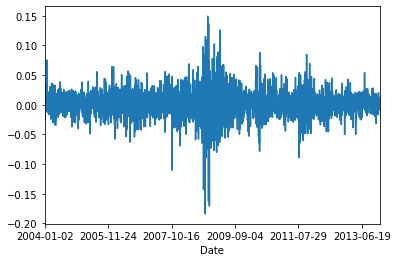

In [100]:
df_data["-".join([isin,"P"])].pct_change(1).plot()

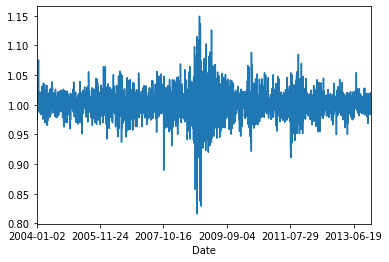

In [150]:
(1+df_data["-".join([isin,"P"])].pct_change(1)).plot()

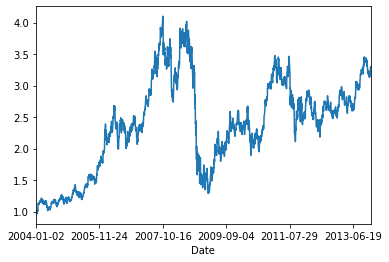

In [151]:
(1 + df_data["-".join([isin,"P"])].pct_change(1)).cumprod().plot()

In [153]:
# >> cum_returns = (1 + final).cumprod() 
# >> drawdown =  1 - final.div(final.cummax()) 
# div Get Floating division of dataframe and other, element-wise (binary operator truediv).
# cummax Returns a DataFrame or Series of the same size containing the cumulative maximum.

# >> drawdown.expanding().max() Provide expanding transformations.


In [146]:
drawdown = 1 - df_data["-".join([isin,"P"])].pct_change(1).div(df_data["-".join([isin,"P"])].pct_change(1).cummax())

In [161]:
drawdown[:10]

Date
2004-01-02         NaN
2004-01-05    0.000000
2004-01-06    1.695073
2004-01-07    2.592715
2004-01-08    0.639743
2004-01-09    0.820875
2004-01-12    1.774052
2004-01-13    0.819196
2004-01-14    1.336554
2004-01-15    1.640401
Name: AN8068571086-P, dtype: float64

In [162]:
df_data["-".join([isin,"P"])][:10
                             ]

Date
2004-01-02    27.330
2004-01-05    27.755
2004-01-06    27.455
2004-01-07    26.775
2004-01-08    26.925
2004-01-09    27.000
2004-01-12    26.675
2004-01-13    26.750
2004-01-14    26.610
2004-01-15    26.345
Name: AN8068571086-P, dtype: float64

In [163]:
df_data["-".join([isin,"P"])].pct_change(1)[:10]

Date
2004-01-02         NaN
2004-01-05    0.015551
2004-01-06   -0.010809
2004-01-07   -0.024768
2004-01-08    0.005602
2004-01-09    0.002786
2004-01-12   -0.012037
2004-01-13    0.002812
2004-01-14   -0.005234
2004-01-15   -0.009959
Name: AN8068571086-P, dtype: float64

In [164]:
df_data["-".join([isin,"P"])].pct_change(1).cummax()[:10]

Date
2004-01-02         NaN
2004-01-05    0.015551
2004-01-06    0.015551
2004-01-07    0.015551
2004-01-08    0.015551
2004-01-09    0.015551
2004-01-12    0.015551
2004-01-13    0.015551
2004-01-14    0.015551
2004-01-15    0.015551
Name: AN8068571086-P, dtype: float64

In [158]:
drawdown.expanding().max()


Date
2004-01-02         NaN
2004-01-05    0.000000
2004-01-06    1.695073
2004-01-07    2.592715
2004-01-08    2.592715
                ...   
2013-12-25    2.884651
2013-12-26    2.884651
2013-12-27    2.884651
2013-12-30    2.884651
2013-12-31    2.884651
Name: AN8068571086-P, Length: 2642, dtype: float64

Compute the Drawdown. 

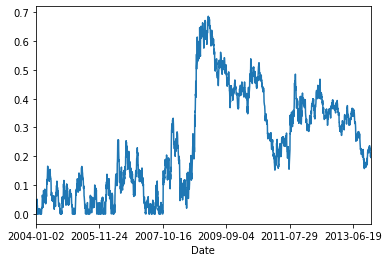

In [172]:
def f_drawdown(returns):
    cum_returns = (1 + returns).cumprod()
    return  1 - cum_returns.div(cum_returns.cummax())
    
df_returns = df_data["-".join([isin,"P"])].pct_change(1)
cum_returns = (1 + df_returns).cumprod()
drawdown =  1 - cum_returns.div(cum_returns.cummax())
drawdown.plot()

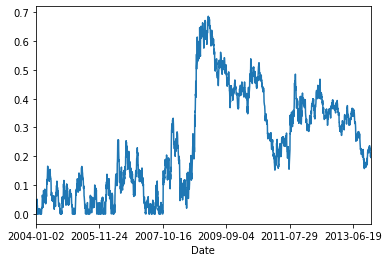

In [173]:
f_drawdown(df_data["-".join([isin,"P"])].pct_change(1)).plot()

In [179]:
f_drawdown(df_data["-".join([isin,"P"])].pct_change(1)).max()

0.6860558479793024

In [180]:
drawdown.idxmax()

'2009-02-23'

In [ ]:
# Returns of MA is shit !!

0    1.0
dtype: float64


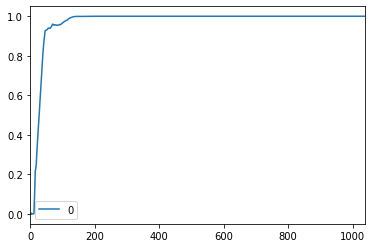

In [187]:
print(f_drawdown(df_return).max())
f_drawdown(df_return).plot()

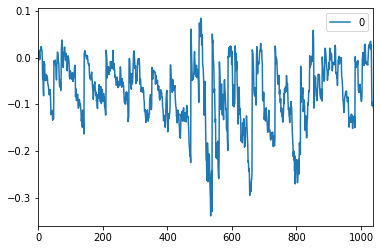

In [186]:
df_return.plot()